# Unidad 3. Problema 3

En el archivo *crime_data.csv* se encuentra el número de crímenes por cada 100.000 habitantes en cada uno de los estados de Estados Unidos, así como el porcentaje de la población que es urbana. Los crímenes se han agrupado en: asalto, asesinato y violación.

Segmenta este conjunto de datos utilizando k-means y obtén los centroides de cada clúster y el listado de los estados en cada uno de los clústeres. Para ello, se ha de encontrar el número óptimo de clúster en el que se divide el conjunto de datos.

In [283]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Carga y Vista Preliminar de Datos

In [290]:
crime = pd.read_csv('crime_data.csv')

In [242]:
crime.head()

,State,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [5]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   State     50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


No tenemos valores nulos, no hay necesidad de imputar valores perdidos.

In [7]:
np.round(crime.describe(),2)

,Murder,Assault,UrbanPop,Rape
count,50.00,50.00,50.00,50.00
mean,7.79,170.76,65.54,21.23
std,4.36,83.34,14.47,9.37
min,0.80,45.00,32.00,7.30
25%,4.08,109.00,54.50,15.08
50%,7.25,159.00,66.00,20.10
75%,11.25,249.00,77.75,26.17
max,17.40,337.00,91.00,46.00


Ahora que tenemos una idea sobre los datos estadisticos de nuestro dataset, seria buena idea tener una idea general de como las diferentes variables se distribuyen segun los diferentes estados, por eso vamos a ver los maximos y minimos de cada variable y ver a que estados corresponden.

In [65]:
print(crime.iloc[crime['Assault'].argmax()])
print('')
print(crime.iloc[crime['Assault'].argmin()])

State       North Carolina
Murder                  13
Assault                337
UrbanPop                45
Rape                  16.1
Name: 32, dtype: object

State       North Dakota
Murder               0.8
Assault               45
UrbanPop              44
Rape                 7.3
Name: 33, dtype: object


In [64]:
print(crime.iloc[crime['Murder'].argmax()])
print('')
print(crime.iloc[crime['Murder'].argmin()])

State       Georgia
Murder         17.4
Assault         211
UrbanPop         60
Rape           25.8
Name: 9, dtype: object

State       North Dakota
Murder               0.8
Assault               45
UrbanPop              44
Rape                 7.3
Name: 33, dtype: object


In [63]:
print(crime.iloc[crime['Rape'].argmax()])
print('')
print(crime.iloc[crime['Rape'].argmin()])

State       Nevada
Murder        12.2
Assault        252
UrbanPop        81
Rape            46
Name: 27, dtype: object

State       North Dakota
Murder               0.8
Assault               45
UrbanPop              44
Rape                 7.3
Name: 33, dtype: object


Vemos como los estados que tienen el mayor proporcion de estas variables corresponden con el sur de Estados Unidos, mientras que el minimo siempre se da en Dakota del Norte que forma parte del Medio Oeste americano, y tiene el nivel minimo de porcentaje de poblacion urbana.

## Analisis Exploratorio de Datos

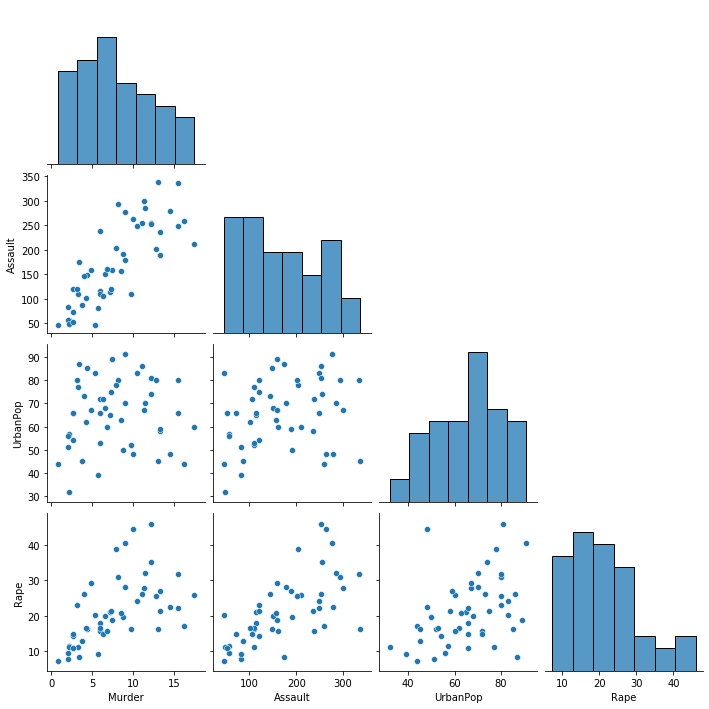

In [25]:
sns.pairplot(crime, corner = True)

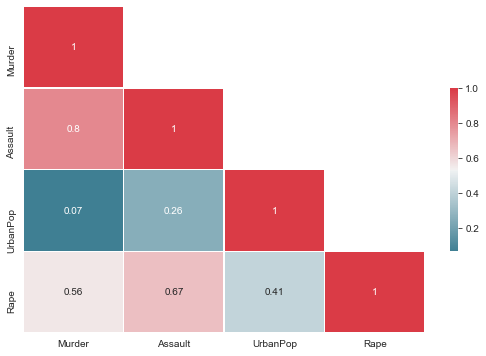

In [285]:
# Matrix de correlacion
corr_crime = crime.corr() 

# Mascara triangular superior
mascara = corr_crime.where(np.tril(np.ones(corr_crime.shape)).astype(np.bool))

plt.figure(figsize=(9,6)) 

# Genera un colormap customizado
cmap = sns.diverging_palette(220, 10, as_cmap=True)

corrmap=sns.heatmap(mascara, annot = True, cmap = cmap, linewidths=.5, cbar_kws={"shrink": .5})  

### Conclusiones del Analisis Exploratorio de Datos

* No parece haber correlacion entre la poblacion urbana y los asesinatos, aunque si que la hay entre la poblacion urbana y las violaciones.

* Los asesinatos y los asaltos tienen un indice de correlacion del 0.8 por lo que podrian incidir en colinearidad.

* Las violaciones estan correlacionadas con el resto de variables en diferentes grados.

## Modelo K-Means Clustering

Crearemos un modelo de clusters usando el agoritmo de K-medias.

In [291]:
from sklearn.cluster import KMeans

X = crime[['Murder' , 'Assault' ,'Rape', 'UrbanPop']].iloc[: , :].values # Matriz de caracteristicas sin estados
inertia = [] # lista donde almacenaremos los valores de la inercia.
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 42  , algorithm= 'full') )
    algorithm.fit(X) # Ajustamos el algoritmo a nuestros datos
    inertia.append(algorithm.inertia_) # anadimos las inercias de cada iteracion a nuestra lista

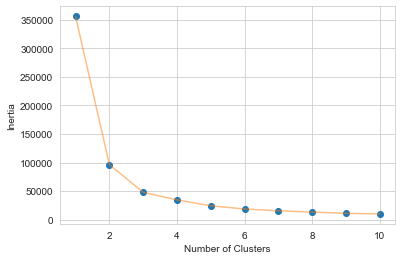

In [292]:
sns.set_style("whitegrid")
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

Para encontrar el numero optimo de clasters para agrupar nuestros datos, tenemos que fijarnos en el 'codo' que dibuja la grafica de las inercias, no parece estar claro si este codo se encuentra en el valor 2 o el valor 3, asi que tendremos que ayudaronos de la metrica de *Scikit Learn* llamada *silhouette_score* para calcular el valor optimo del numero de clusters.

In [293]:
from sklearn.metrics import silhouette_score

def plot_sillhouette(Blob, figure_name, max_k = 10, n_init = 10): 
    sillhouette_avgs = []
    
    for k in range(2, max_k):
        kmean = KMeans(n_clusters = k, n_init = n_init).fit(Blob)
        sillhouette_avgs.append(silhouette_score(Blob, kmean.labels_))
        
    plt.plot(range(2, max_k), sillhouette_avgs)
    plt.title(figure_name)

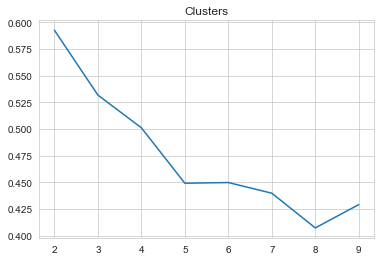

In [294]:
plot_sillhouette(X, 'Clusters')

Parece que el valor optimo de clusters es 2. Asi que describiremos nuestros datos en torno a estos dos clusters.

### Centroides de Clusters

In [295]:
kmeans = KMeans(n_clusters = 2, n_init = 10).fit(X)
centroides = kmeans.cluster_centers_
centroides

array([[  4.84137931, 109.75862069,  16.24827586,  64.03448276],
       [ 11.85714286, 255.        ,  28.11428571,  67.61904762]])

El centroide del primer cluster (**Cluster 0**) da: ~4.84 asesinatos por cada 100.000 habitantes, ~109.76 asaltos por cada 100.000 habitantes y ~16.25 violaciones por cada 100.000 habitantes, ademas de una poblacion urbana del ~64%.

El centroide del segundo cluster (**Cluster 1**) da: ~11.86, 255, ~28.11 y ~67.62% respectivamente.

Podemos ver que el los clusters se han dividido entre estados de alta criminalidad y estados de baja criminalidad, donde la poblacion urbana no parece ser muy relevante ya que, mientras que en el cluster de baja criminalidad la poblacion urbana es mas baja, la diferencia entre ambos clusters en poblacion urbana es apenas del 3.62% aproximadamente.

### Estados que Pertenecen a Cada Cluster

In [300]:
clust = kmeans.predict(X)

for i in range(max(clust) + 1):
    print ("Cluster", i)
    print (crime["State"][clust == i])

Cluster 0
6       Connecticut
10           Hawaii
11            Idaho
13          Indiana
14             Iowa
15           Kansas
16         Kentucky
18            Maine
20    Massachusetts
22        Minnesota
24         Missouri
25          Montana
26         Nebraska
28    New Hampshire
29       New Jersey
33     North Dakota
34             Ohio
35         Oklahoma
36           Oregon
37     Pennsylvania
38     Rhode Island
40     South Dakota
43             Utah
44          Vermont
45         Virginia
46       Washington
47    West Virginia
48        Wisconsin
49          Wyoming
Name: State, dtype: object
Cluster 1
0            Alabama
1             Alaska
2            Arizona
3           Arkansas
4         California
5           Colorado
7           Delaware
8            Florida
9            Georgia
12          Illinois
17         Louisiana
19          Maryland
21          Michigan
23       Mississippi
27            Nevada
30        New Mexico
31          New York
32    North Caro

In [301]:
crime['Cluster'] = clust # Anadimos a que cluster pertenece cada estado como variable dentro del dataset

In [302]:
crime

,State,Murder,Assault,UrbanPop,Rape,Cluster
0,Alabama,13.2,236,58,21.2,1
1,Alaska,10.0,263,48,44.5,1
2,Arizona,8.1,294,80,31.0,1
3,Arkansas,8.8,190,50,19.5,1
4,California,9.0,276,91,40.6,1
5,Colorado,7.9,204,78,38.7,1
6,Connecticut,3.3,110,77,11.1,0
7,Delaware,5.9,238,72,15.8,1
8,Florida,15.4,335,80,31.9,1
9,Georgia,17.4,211,60,25.8,1


### Representacion Grafica Aproximada de cada Cluster

Al contar nuestro dataset con 4 dimensiones, ademas de las etiquetas (Estados), no seria posible representar graficamente nuestros clusters. Lo que si podriamos hacer es una representacion grafica aproximada usando tres dimensiones y usando un color para cada cluster.

Como vimos anteriormente, la variable asesinatos tenia un alto nivel de correlacion con la variable asaltos, y de estas dos variables, la que estaba mas correlacionada con el resto era la variable asaltos. Asi que eliminaremos la variable asesinatos para nuestra representacion grafica aproximada.

En el siguiente grafico veremos como, efectivamente, un cluster agrupa a aquellos estados con menor criminalidad (**Cluster 0**) y el otro cluster a aquellos con mayor criminalidad (**Cluster 1**)

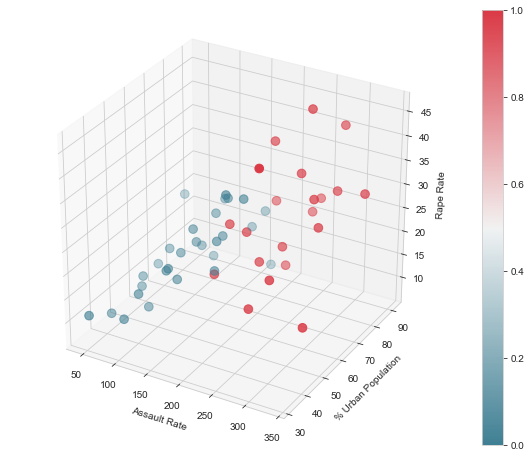

In [269]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111, projection='3d')

x = crime['Assault']
y = crime['UrbanPop']
z = crime['Rape']
c = crime['Cluster']

ax.set_xlabel("Assault Rate")
ax.set_ylabel("% Urban Population")
ax.set_zlabel("Rape Rate", rotation = 0)

img = ax.scatter(x, y, z, c= c, cmap = sns.diverging_palette(220, 10, as_cmap=True), s = 75)
fig.colorbar(img)
plt.show()

### Estadisticos Descriptivos de cada Cluster

Podemos verificar nuestro enunciado de la diferencia en criminalidad entre ambos clusters observando sus estadisticos descriptivos.

In [303]:
cluster0 = crime[crime['Cluster'] == 0].drop('Cluster', axis = 1)
cluster1 = crime[crime['Cluster'] == 1].drop('Cluster', axis = 1)

In [304]:
np.round(cluster0.describe(),2)

,Murder,Assault,UrbanPop,Rape
count,29.00,29.00,29.00,29.00
mean,4.84,109.76,64.03,16.25
std,2.35,41.32,14.39,5.97
min,0.80,45.00,32.00,7.30
25%,2.70,81.00,54.00,11.20
50%,4.40,110.00,66.00,16.30
75%,6.60,149.00,73.00,20.20
max,9.70,178.00,89.00,29.30


In [305]:
np.round(cluster1.describe(),2)

,Murder,Assault,UrbanPop,Rape
count,21.00,21.00,21.00,21.00
mean,11.86,255.00,67.62,28.11
std,2.96,42.17,14.68,8.90
min,5.90,188.00,44.00,15.80
25%,10.00,236.00,58.00,22.20
50%,12.10,254.00,70.00,26.10
75%,13.20,279.00,80.00,32.10
max,17.40,337.00,91.00,46.00


## Representacion Geografica de cada Cluster

Seria interesante ver en un mapa que estados pertenecen a cada cluster, por ello usaremos un mapa *choropleth* de Estados Unidos de la libreria *plotly*. 

In [273]:
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected = True)

La libreria *plotly* solo acepta las abreviaturas oficiales de los estados de Estados Unidos, por ello usaremos un diccionario y crearemos una una variable en nuestro dataset usando estas abreviaturas a la que llamaremos *State Code*:

In [274]:
state_codes = { 
    'District of Columbia' : 'dc','Mississippi': 'MS', 'Oklahoma': 'OK', 
    'Delaware': 'DE', 'Minnesota': 'MN', 'Illinois': 'IL', 'Arkansas': 'AR', 
    'New Mexico': 'NM', 'Indiana': 'IN', 'Maryland': 'MD', 'Louisiana': 'LA', 
    'Idaho': 'ID', 'Wyoming': 'WY', 'Tennessee': 'TN', 'Arizona': 'AZ', 
    'Iowa': 'IA', 'Michigan': 'MI', 'Kansas': 'KS', 'Utah': 'UT', 
    'Virginia': 'VA', 'Oregon': 'OR', 'Connecticut': 'CT', 'Montana': 'MT', 
    'California': 'CA', 'Massachusetts': 'MA', 'West Virginia': 'WV', 
    'South Carolina': 'SC', 'New Hampshire': 'NH', 'Wisconsin': 'WI',
    'Vermont': 'VT', 'Georgia': 'GA', 'North Dakota': 'ND', 
    'Pennsylvania': 'PA', 'Florida': 'FL', 'Alaska': 'AK', 'Kentucky': 'KY', 
    'Hawaii': 'HI', 'Nebraska': 'NE', 'Missouri': 'MO', 'Ohio': 'OH', 
    'Alabama': 'AL', 'Rhode Island': 'RI', 'South Dakota': 'SD', 
    'Colorado': 'CO', 'New Jersey': 'NJ', 'Washington': 'WA', 
    'North Carolina': 'NC', 'New York': 'NY', 'Texas': 'TX', 
    'Nevada': 'NV', 'Maine': 'ME'}

crime['State Code'] = crime['State'].apply(lambda x : state_codes[x])

In [275]:
data = dict(type = 'choropleth', 
             locations = crime['State Code'],
             locationmode = 'USA-states',
             colorscale= ["rgb(166,206,227)","rgb(251,154,153)"], 
             text = crime['State'], 
             z = crime['Cluster'], 
             marker = dict(line = dict(color = 'rgb(12,12,12)', width = 1)), 
             colorbar = {'title' : 'Crime Clusters'})

In [277]:
layout = dict(title = 'Crime Clusters',
             geo = dict(scope = 'usa', showlakes = True, lakecolor = 'rgb(85,173, 240)'))

In [278]:
choromap = go.Figure(data = [data],layout = layout)
iplot(choromap,validate=False)

Vemos como el **cluster 0** de menor criminalidad esta presente en el norte del pais, especialmente en lo que se conoce como el Medio Oeste. El **cluster 1**, sin embargo, se encuentra sobre todo en el sur del pais y la zona de los grandes lagos. 